In [10]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import neighbors

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
pd.set_option("display.max_rows", None)

# 1. Task 1

### 1.1 Subset those that have made a donation (Target B = 1).

In [4]:
numerical = pd.read_csv('numerical.csv')
categorical = pd.read_csv('categorical.csv')
target = pd.read_csv('target.csv')

In [5]:
data = pd.concat([numerical, categorical, target], axis = 1)

In [6]:
data = data[data['TARGET_B']==1].reset_index(drop = True)

In [ ]:
# data

### 1.2 Create a regression model to predict how much they will donate (Target D).

In [7]:
X = data.drop(['TARGET_B', 'TARGET_D'], axis = 1)
y = data['TARGET_D']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train_cat = X_train.select_dtypes(include='object').reset_index(drop=True)
X_train_num = X_train.select_dtypes(include='number').reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test_cat = X_test.select_dtypes(include='object').reset_index(drop=True)
X_test_num = X_test.select_dtypes(include='number').reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [8]:
encoder = OneHotEncoder(drop='first').fit(X_train_cat)

encoded_categorical_train = encoder.transform(X_train_cat).toarray()
encoded_categorical_train = pd.DataFrame(encoded_categorical_train, columns=encoder.get_feature_names_out())

encoded_categorical_test = encoder.transform(X_test_cat).toarray()
encoded_categorical_test = pd.DataFrame(encoded_categorical_test, columns=encoder.get_feature_names_out())

In [ ]:
# scaler = StandardScaler().fit(X_train_num)

# scaled_numerical_train = scaler.transform(X_train_num)
# scaled_numerical_train = pd.DataFrame(scaled_numerical_train, columns = X_train_num.columns)

# scaled_numerical_test = scaler.transform(X_test_num)
# scaled_numerical_test = pd.DataFrame(scaled_numerical_test, columns = X_train_num.columns)

In [11]:
scaler = MinMaxScaler().fit(X_train_num)

scaled_numerical_train = scaler.transform(X_train_num)
scaled_numerical_train = pd.DataFrame(scaled_numerical_train, columns = X_train_num.columns)

scaled_numerical_test = scaler.transform(X_test_num)
scaled_numerical_test = pd.DataFrame(scaled_numerical_test, columns = X_train_num.columns)

In [12]:
X_train = pd.concat([encoded_categorical_train, scaled_numerical_train], axis = 1).reset_index(drop = True)
X_test = pd.concat([encoded_categorical_test, scaled_numerical_test], axis = 1).reset_index(drop = True)

In [ ]:
# lm = LinearRegression()
# lm.fit(X_train, y_train)

In [ ]:
# lm.score(X_test, y_test)

> The score is very low. I´ll select features with pca.

In [ ]:
# pca = PCA(0.90)
# pca.fit(X_train)

In [ ]:
# X_train_pca = pca.transform(X_train)
# X_test_pca = pca.transform(X_test)

# X_train_pca = pd.DataFrame(X_train_pca).reset_index(drop=True)
# X_test_pca = pd.DataFrame(X_test_pca).reset_index(drop=True)

In [ ]:
# lm2 = LinearRegression()
# lm2.fit(X_train_pca, y_train)

In [ ]:
# lm2.score(X_test_pca, y_test)

> The score is still too low. I´ll select features based on correlation with the target and drop multicolinearity.

In [ ]:
some_corr = []

for col in X_train.columns:
    if X_train[col].corr(y_train) >= 0.2 or X_train[col].corr(y_train) <= -0.2:
        some_corr.append(col)

In [ ]:
# some_corr

In [ ]:
X_train_corr = X_train[['RFA_2A_E',
 'RFA_2A_G',
 'RAMNTALL',
 'NGIFTALL',
 'CARDGIFT',
 'MINRAMNT',
 'MAXRAMNT',
 'LASTGIFT',
 'AVGGIFT',
 'RFA_2F']]

In [ ]:
# corr = X_train_corr.corr()

In [ ]:
# fig, ax = plt.subplots()
# sns.heatmap(corr, cmap="crest", xticklabels=True, yticklabels=True, ax=ax)

In [ ]:
X_train_corr = X_train_corr.drop(['NGIFTALL', 'MINRAMNT', 'LASTGIFT'], axis=1)

In [ ]:
X_test_corr = X_test[X_train_corr.columns]

In [ ]:
# lm = LinearRegression()
# lm.fit(X_train_corr, y_train)

In [ ]:
# lm.score(X_test_corr, y_test)

> I´ll try with nearest neighbours

In [ ]:
scores = []

for k in range(2,30):
    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(X_train_corr, y_train)
    scores.append(model.score(X_test_corr, y_test))

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(range(2,30), scores)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
model = KNeighborsRegressor(n_neighbors = 24)
model.fit(X_train_corr, y_train)

In [ ]:
model.score(X_test_corr, y_test)

> Maybe what happens is that the features have too low variance.

In [61]:
# X_train.describe()

In [60]:
# X_train.head()

In [20]:
X_train['STATE_FL'].var()

0.0766595472327967

In [66]:
col_var = []

for col in X_train.columns:
    if X_train[col].var() >= 0.1:
        col_var.append(col)

In [67]:
col_var

['STATE_other',
 'HOMEOWNR_U',
 'GENDER_M',
 'RFA_2A_E',
 'RFA_2A_F',
 'RFA_2A_G',
 'GEOCODE2_B',
 'GEOCODE2_C',
 'GEOCODE2_D',
 'DOMAIN_A_R',
 'DOMAIN_A_S',
 'DOMAIN_A_T',
 'DOMAIN_A_U',
 'POP90C1',
 'POP90C3',
 'HVP2',
 'HVP3',
 'HVP4',
 'RP1',
 'RP2',
 'RP3',
 'LFC9',
 'HC6',
 'HC7',
 'HC11',
 'HC19',
 'HPHONE_D',
 'RFA_2F',
 'MINRDATE_MM',
 'MAXRDATE_MM',
 'LASTDATE_MM',
 'FIRSTDATE_MM']

In [68]:
X_train_var = X_train[['STATE_other',
 'HOMEOWNR_U',
 'GENDER_M',
 'RFA_2A_E',
 'RFA_2A_F',
 'RFA_2A_G',
 'GEOCODE2_B',
 'GEOCODE2_C',
 'GEOCODE2_D',
 'DOMAIN_A_R',
 'DOMAIN_A_S',
 'DOMAIN_A_T',
 'DOMAIN_A_U',
 'POP90C1',
 'POP90C3',
 'HVP2',
 'HVP3',
 'HVP4',
 'RP1',
 'RP2',
 'RP3',
 'LFC9',
 'HC6',
 'HC7',
 'HC11',
 'HC19',
 'HPHONE_D',
 'RFA_2F',
 'MINRDATE_MM',
 'MAXRDATE_MM',
 'LASTDATE_MM',
 'FIRSTDATE_MM']]

In [69]:
corr = X_train_var.corr()

<Axes: >

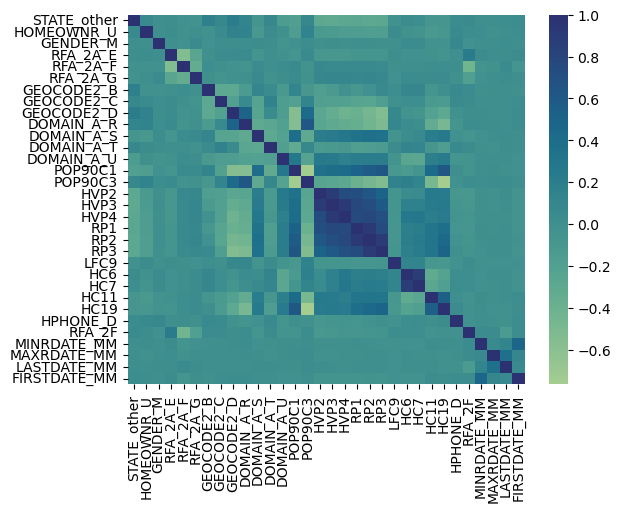

In [70]:
fig, ax = plt.subplots()
sns.heatmap(corr, cmap="crest", xticklabels=True, yticklabels=True, ax=ax)

In [71]:
X_test_var = X_test_var.drop(['HVP3', 'RP2', 'HC7'], axis=1)

In [72]:
X_test_var = X_test[X_train_var.columns]

In [79]:
scores = []

for k in range(2,50):
    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(X_train_var, y_train)
    scores.append(model.score(X_test_var, y_test))

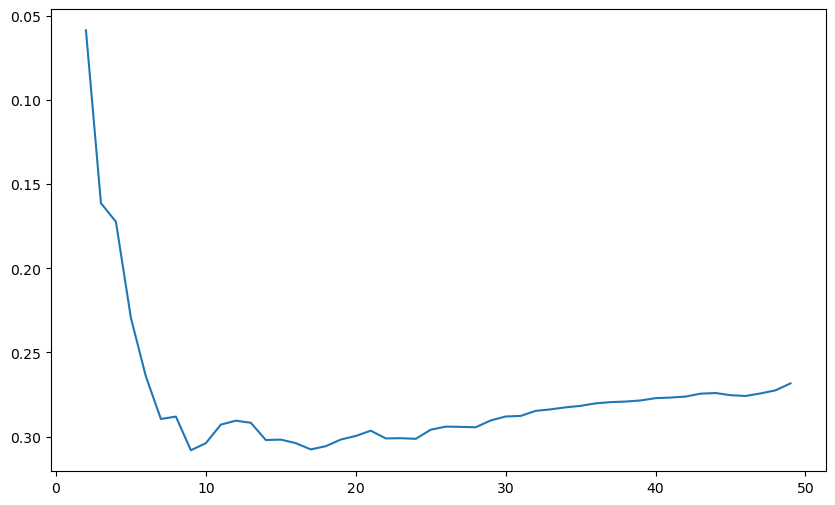

In [80]:
plt.figure(figsize = (10,6))
plt.plot(range(2,50), scores)
plt.gca().invert_yaxis()
plt.show()

In [87]:
model = KNeighborsRegressor(n_neighbors = 7)
model.fit(X_train_var, y_train)

KNeighborsRegressor(n_neighbors=7)

In [88]:
model.score(X_test_var, y_test)

0.28956870893504905

> This model is not valid.